<a href="https://colab.research.google.com/github/VeroshaKriyanjala/Second-Hand-Product-Value-Predictor/blob/main/used_car_price_prediction_20_years_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A (good) used car is a better (depreciating) asset to own than a new one

Using this Craigslist used car dataset and considering the last 20 years' worth of data I use the below algorithms to best predict the value of used cars, based on 10 features

* Linear Regression
* Decision Trees
* Bagging
* Random Forest
* Adaptive Boosting
* Gradient Boosting
* XGBoost


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install missingno to visualize missing data
#!pip install missingno

# Install xgboost - an algorithm used in this project
#!pip install xgboost

# Utilities
import os

# Numpy & Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#import pandas_profiling as pp

# Models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn import metrics
import missingno as msno

# Others (warnings etc)
from warnings import simplefilter
%matplotlib inline


In [4]:
vehicles_df_full=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vehicles.csv')

In [5]:
# Declare variables required
DASHES = '-' * 10
TABS = '\t' * 8
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 12)
pd.set_option('display.expand_frame_repr', False)
pd.options.display.float_format = '{:,.2f}'.format

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Define a function to show values on bar charts
def show_values_on_bars(axs, space=0.4):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", va="bottom")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


In [6]:
# Read from input file

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/vehicles.csv'):
    for filename in filenames:
        with open(os.path.join(dirname, filename),  encoding='utf-8') as f:
            %time vehicles_df_full = pd.read_csv(f)
            f.close()

# Print read info
print(f'Read {len(vehicles_df_full)} lines from the file vehicles.csv\n\n')

vehicles_df_full.info()

Read 426880 lines from the file vehicles.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  t

<Axes: >

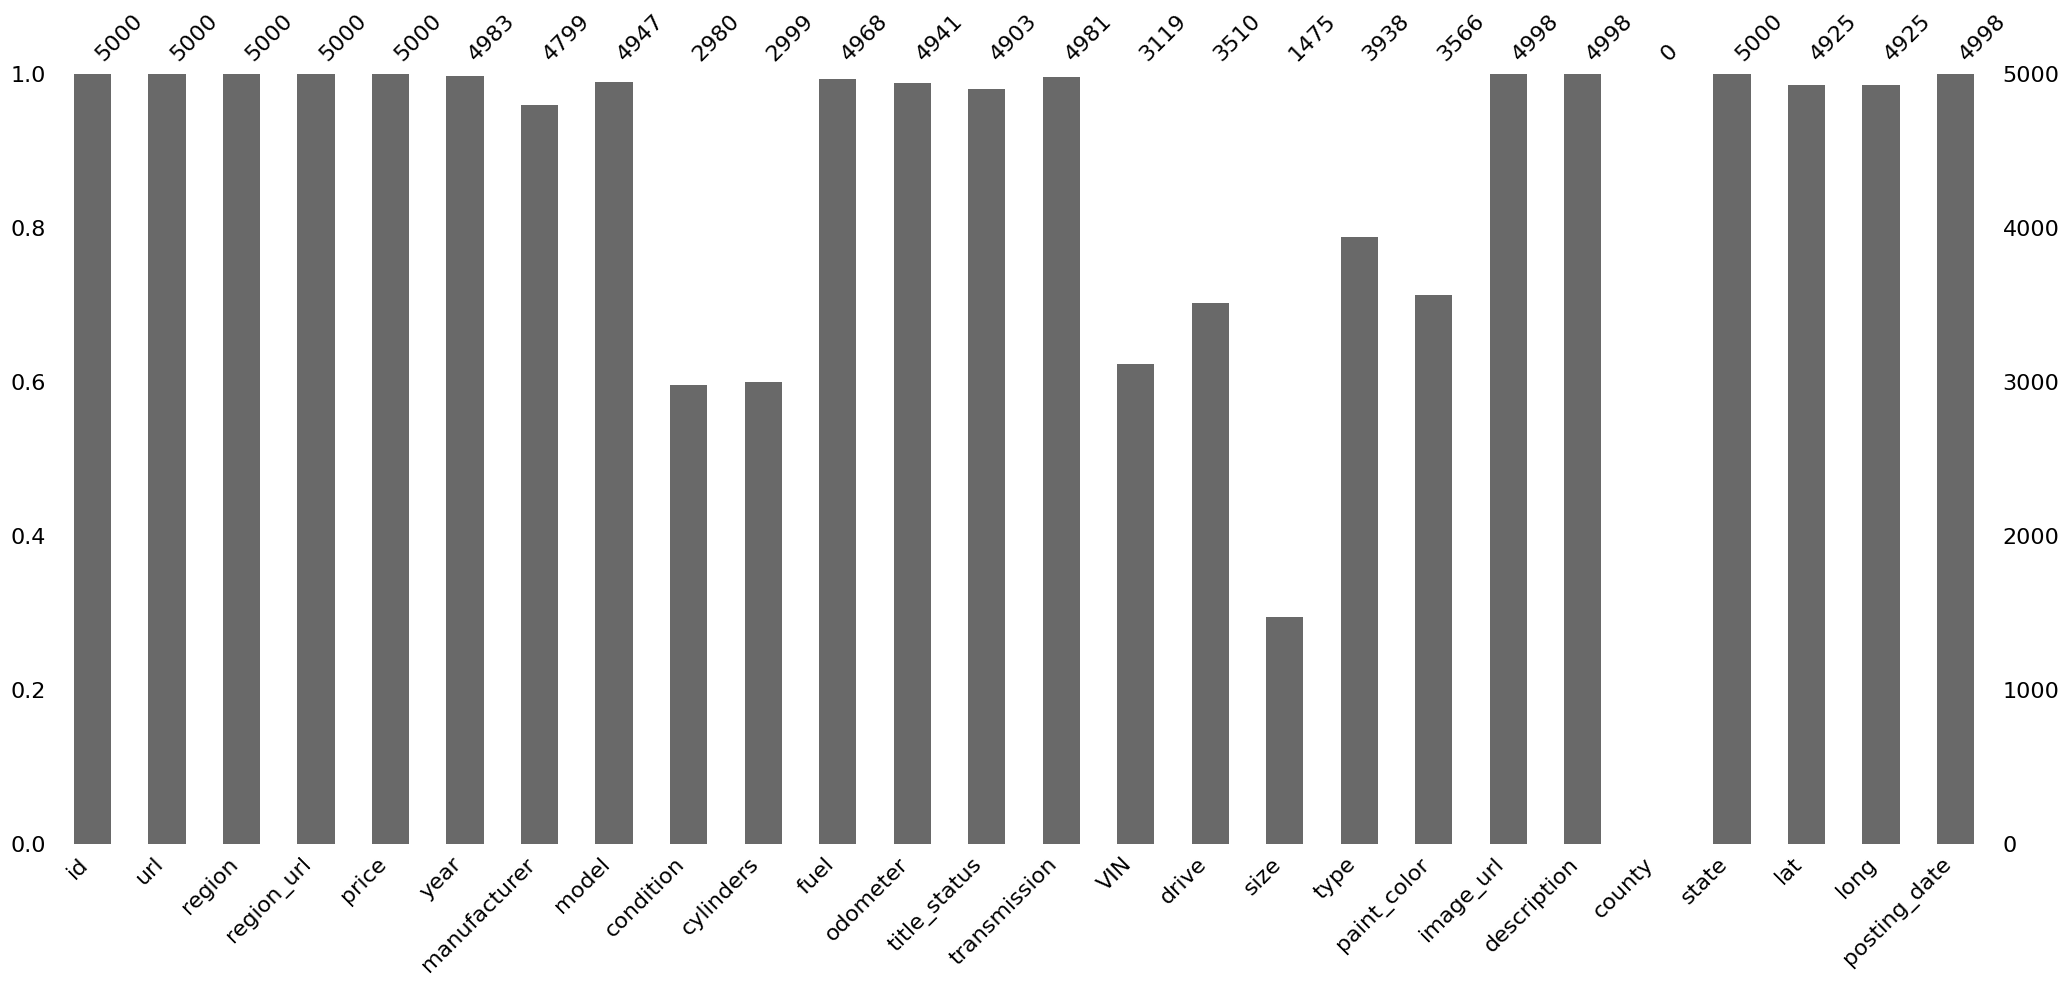

In [7]:
# Review the completeness of data

msno.bar(vehicles_df_full.sample(5000))


In [8]:
# Determine and remove the columns to drop based on the above graph
cols_to_drop = ['id','url', 'region', 'region_url', 'VIN', 'image_url', 'description', \
    'county', 'size', 'paint_color', 'drive', 'cylinders', 'state', 'lat','long']
vehicles_df = vehicles_df_full.drop(columns=cols_to_drop)

# Remove the larger data frame from memory
del vehicles_df_full

# Get info of the new data frame
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   fuel          423867 non-null  object 
 6   odometer      422480 non-null  float64
 7   title_status  418638 non-null  object 
 8   transmission  424324 non-null  object 
 9   type          334022 non-null  object 
 10  posting_date  426812 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 35.8+ MB


In [9]:
# Preview the new dataframe
vehicles_df


,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,posting_date
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,"2,019.00",nissan,maxima s sedan 4d,good,gas,"32,226.00",clean,other,sedan,2021-04-04T03:21:31-0600
426876,30590,"2,020.00",volvo,s60 t5 momentum sedan 4d,good,gas,"12,029.00",clean,other,sedan,2021-04-04T03:21:29-0600
426877,34990,"2,020.00",cadillac,xt4 sport suv 4d,good,diesel,"4,174.00",clean,other,hatchback,2021-04-04T03:21:17-0600
426878,28990,"2,018.00",lexus,es 350 sedan 4d,good,gas,"30,112.00",clean,other,sedan,2021-04-04T03:21:11-0600


>*With the previews and descrption of continuous variables above, it's immedealtely apparent that some first level cleanup is required. Continuing to do so...*

In [10]:
# Initial cleaning up
# Drop NaNs and duplicates
vehicles_df.dropna(inplace=True)
vehicles_df.drop_duplicates(inplace=True)

# Update index and change data type of year to string
vehicles_df.index = range(len(vehicles_df))
vehicles_df.year = vehicles_df.year.astype(int).astype(str)

vehicles_df

,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,posting_date
0,33590,2014,gmc,sierra 1500 crew cab slt,good,gas,"57,923.00",clean,other,pickup,2021-05-04T12:31:18-0500
1,22590,2010,chevrolet,silverado 1500,good,gas,"71,229.00",clean,other,pickup,2021-05-04T12:31:08-0500
2,39590,2020,chevrolet,silverado 1500 crew,good,gas,"19,160.00",clean,other,pickup,2021-05-04T12:31:25-0500
3,30990,2017,toyota,tundra double cab sr,good,gas,"41,124.00",clean,other,pickup,2021-05-04T10:41:31-0500
4,15000,2013,ford,f-150 xlt,excellent,gas,"128,000.00",clean,automatic,truck,2021-05-03T14:02:03-0500
...,...,...,...,...,...,...,...,...,...,...,...
202117,23590,2019,nissan,maxima s sedan 4d,good,gas,"32,226.00",clean,other,sedan,2021-04-04T03:21:31-0600
202118,30590,2020,volvo,s60 t5 momentum sedan 4d,good,gas,"12,029.00",clean,other,sedan,2021-04-04T03:21:29-0600
202119,34990,2020,cadillac,xt4 sport suv 4d,good,diesel,"4,174.00",clean,other,hatchback,2021-04-04T03:21:17-0600
202120,28990,2018,lexus,es 350 sedan 4d,good,gas,"30,112.00",clean,other,sedan,2021-04-04T03:21:11-0600




# Data Visualization & Cleaning
  
Visualizing the data reveals patterns that are not obvious to the human eye when reviewing raw data

Correlation matrices, histograms, category, scatter & box plots have helped identify relationships

Cleaned data based on visualizations:
* Removed NaNs & duplicates
* Price b/w 2k and 50k
* Odometer b/w 100 and 200k, etc..

In the section below, features that would help with better prediction are identified


---






In [11]:
# Describing the dataset to get a basic idea of the non-categorical features
vehicles_df.describe()

,price,odometer
count,"202,122.00","202,122.00"
mean,"44,802.26","91,518.98"
std,"8,689,932.64","193,730.12"
min,0.00,0.00
25%,"6,995.00","30,908.25"
50%,"15,900.00","78,000.00"
75%,"27,990.00","130,000.00"
max,"3,736,928,711.00","10,000,000.00"


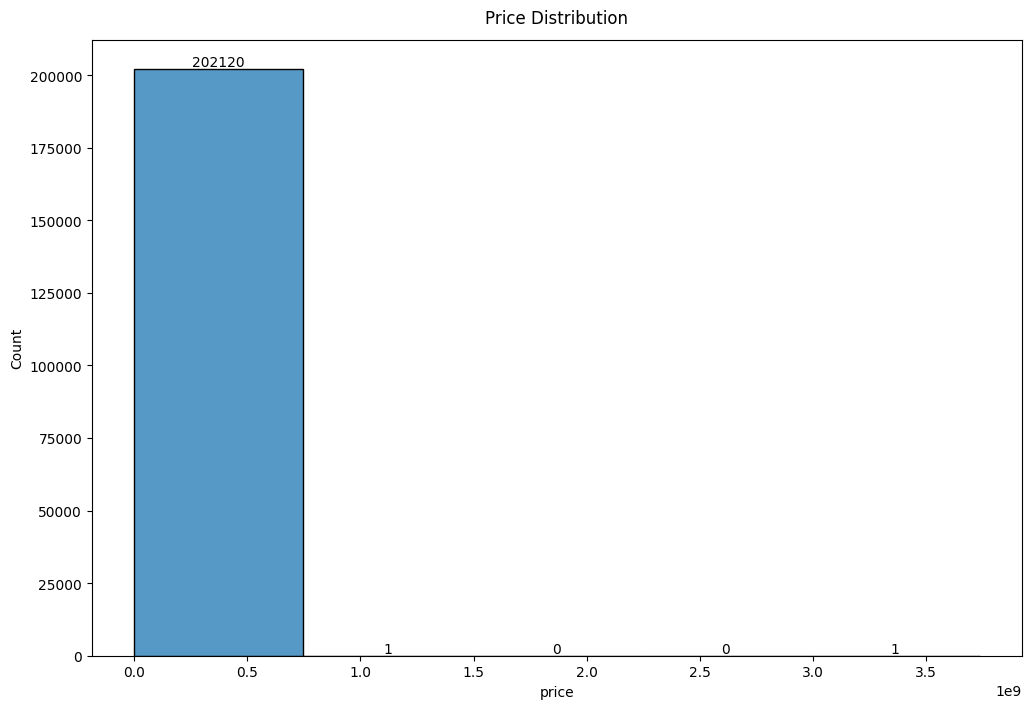

In [12]:
# Looking at the target column "price" first
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price Distribution', pad=12)
sns.histplot(vehicles_df, x="price", stat='count', bins=5)
show_values_on_bars(ax)

*It appears that the price ranges between 0 and an unrealistic $3.7B*

*To keep things simple and realistic, making a subset of prices between 2k and 50k*

---



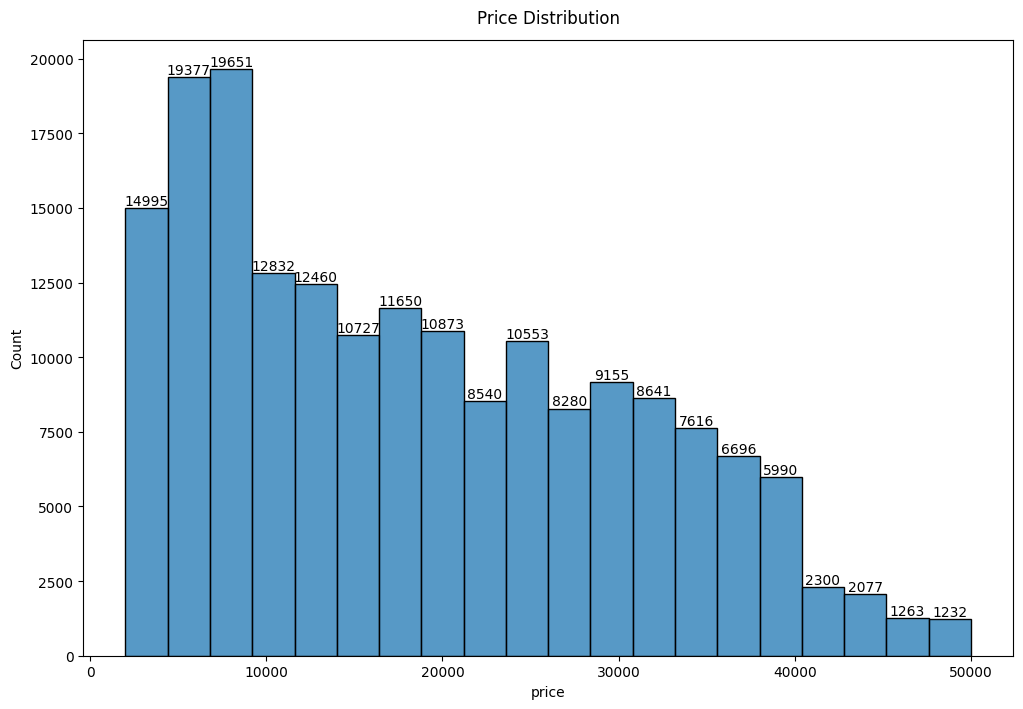

In [13]:
vehicles_prc = vehicles_df[(vehicles_df.price >=2000) & (vehicles_df.price <=50000)]

# Then plot the distriution again
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price Distribution', pad=12)
sns.histplot(vehicles_prc, x="price", stat='count', bins=20)
show_values_on_bars(ax)


Skewness for odometer: 48.58




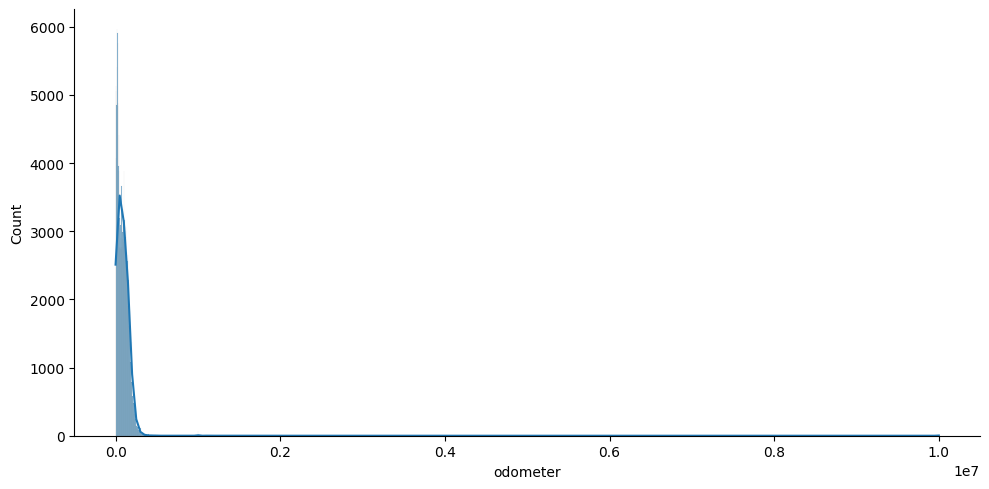

In [14]:

# Check for skewness
print(f"Skewness for odometer: {round(vehicles_prc['odometer'].skew(),2)}\n\n")
sns.displot(data=vehicles_prc, x="odometer", aspect=2, height=5, kde=True)


*It's evident that the distribution is highly skewed and there's some bad data with max odometer readings of 10mil miles etc.*

*Let's work on cleaning up some of that data*

*Doing some research, I found that Americans drive an average of 14,300 miles per year, according to the [Federal Highway Administration](https://www.thezebra.com/resources/driving/average-miles-driven-per-year/).*

*Let's look at the entries for odometer = 0 and odometer > 200k.*



In [15]:
print(vehicles_prc[(vehicles_prc.odometer == 0)].describe())
print('\n')
print(vehicles_prc[(vehicles_prc.odometer > 200000)].describe())

          price  odometer
count    277.00    277.00
mean  13,709.77      0.00
std    9,259.90      0.00
min    2,000.00      0.00
25%    7,495.00      0.00
50%   10,900.00      0.00
75%   18,900.00      0.00
max   49,995.00      0.00


          price      odometer
count  9,371.00      9,371.00
mean   7,702.86    296,067.16
std    6,058.39    600,437.92
min    2,000.00    200,004.00
25%    3,600.00    212,000.00
50%    5,500.00    228,000.00
75%    9,500.00    252,790.00
max   50,000.00 10,000,000.00


 *Based on the stats above, I can make a fair assumption that odometer readings be between 100 (CPO) to 200k (20 yo) will be a good dataset to continue with*

        odometer
count 174,612.00
mean   79,143.34
std    54,218.50
min       101.00
25%    29,979.00
50%    73,099.00
75%   122,000.00
max   200,000.00


Skewness for odometer: 0.37




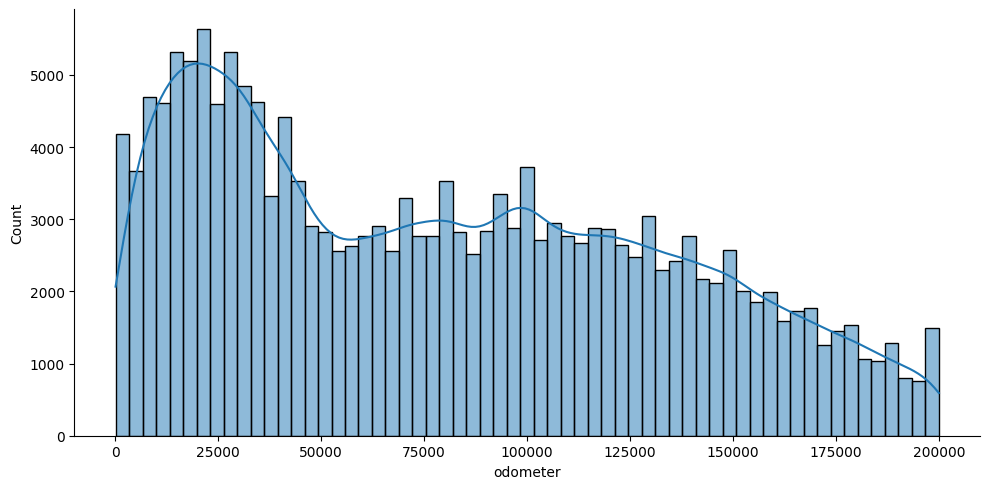

In [16]:
# Filtering the dataset and verifying again
vehicles_odo = vehicles_prc[(vehicles_prc.odometer >100) & (vehicles_prc.odometer <=200000)]

print(pd.DataFrame(vehicles_odo.odometer).describe())

print(f"\n\nSkewness for odometer: {round(vehicles_odo['odometer'].skew(),2)}\n\n")
sns.displot(data=vehicles_odo, x="odometer", aspect=2, height=5, kde=True)


*and with that, the skewness comes down from 41.63 to just 0.37 - although still positively skewed, it's worth exploring what log and square root can do..*

---



Skewness for Log of Odometer Readings: -1.62

Skewness for Square Root of Odometer Readings: -0.2




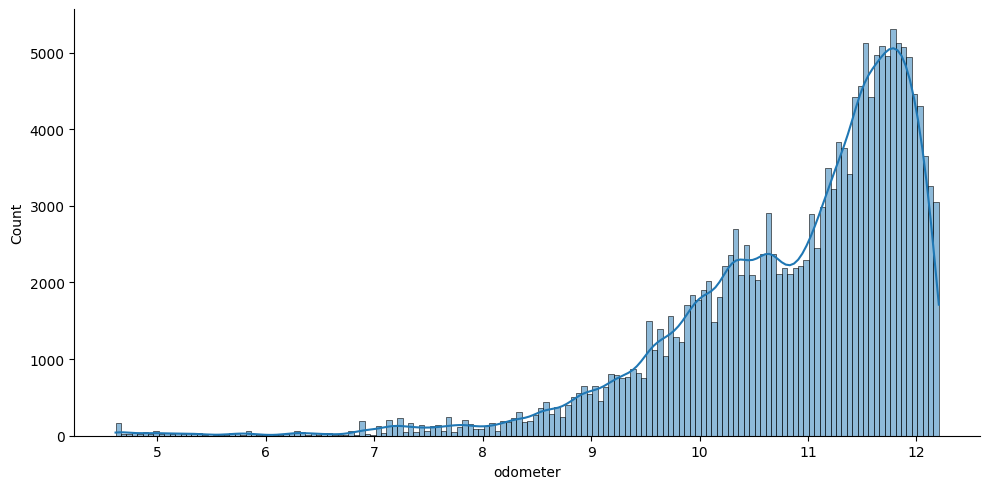

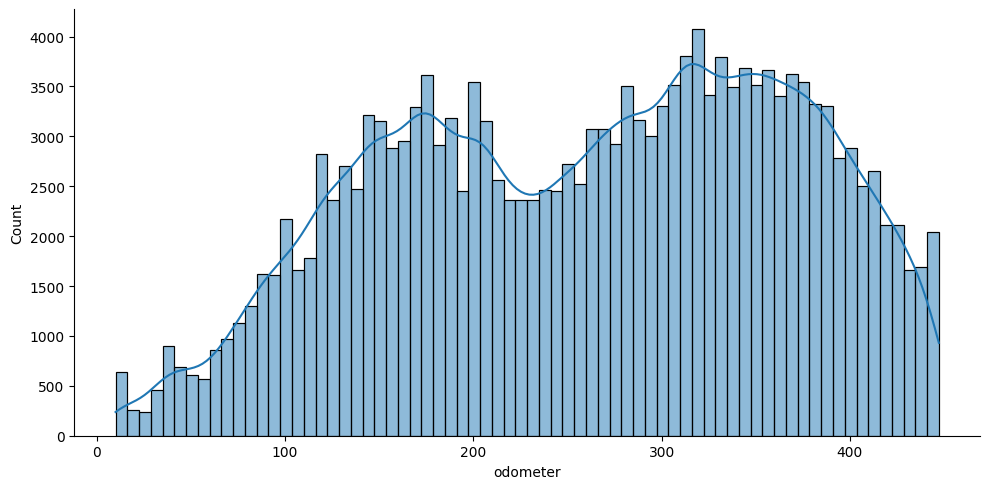

In [17]:

# Log
odo_log = np.log(vehicles_odo['odometer'])
print(f"Skewness for Log of Odometer Readings: {round(odo_log.skew(),2)}\n")
sns.displot(data=odo_log, aspect=2, height=5, kde=True, legend=True)


# Square Root
odo_sqrt = np.sqrt(vehicles_odo['odometer'])
print(f"Skewness for Square Root of Odometer Readings: {round(odo_sqrt.skew(),2)}\n\n")
sns.displot(data=odo_sqrt, aspect=2, height=5, kde=True, legend=True)



*That didn't help.. so proceeding without log or sqrt, next step is to see how the age of cars and the odometer readings are related to the price of cars*


---

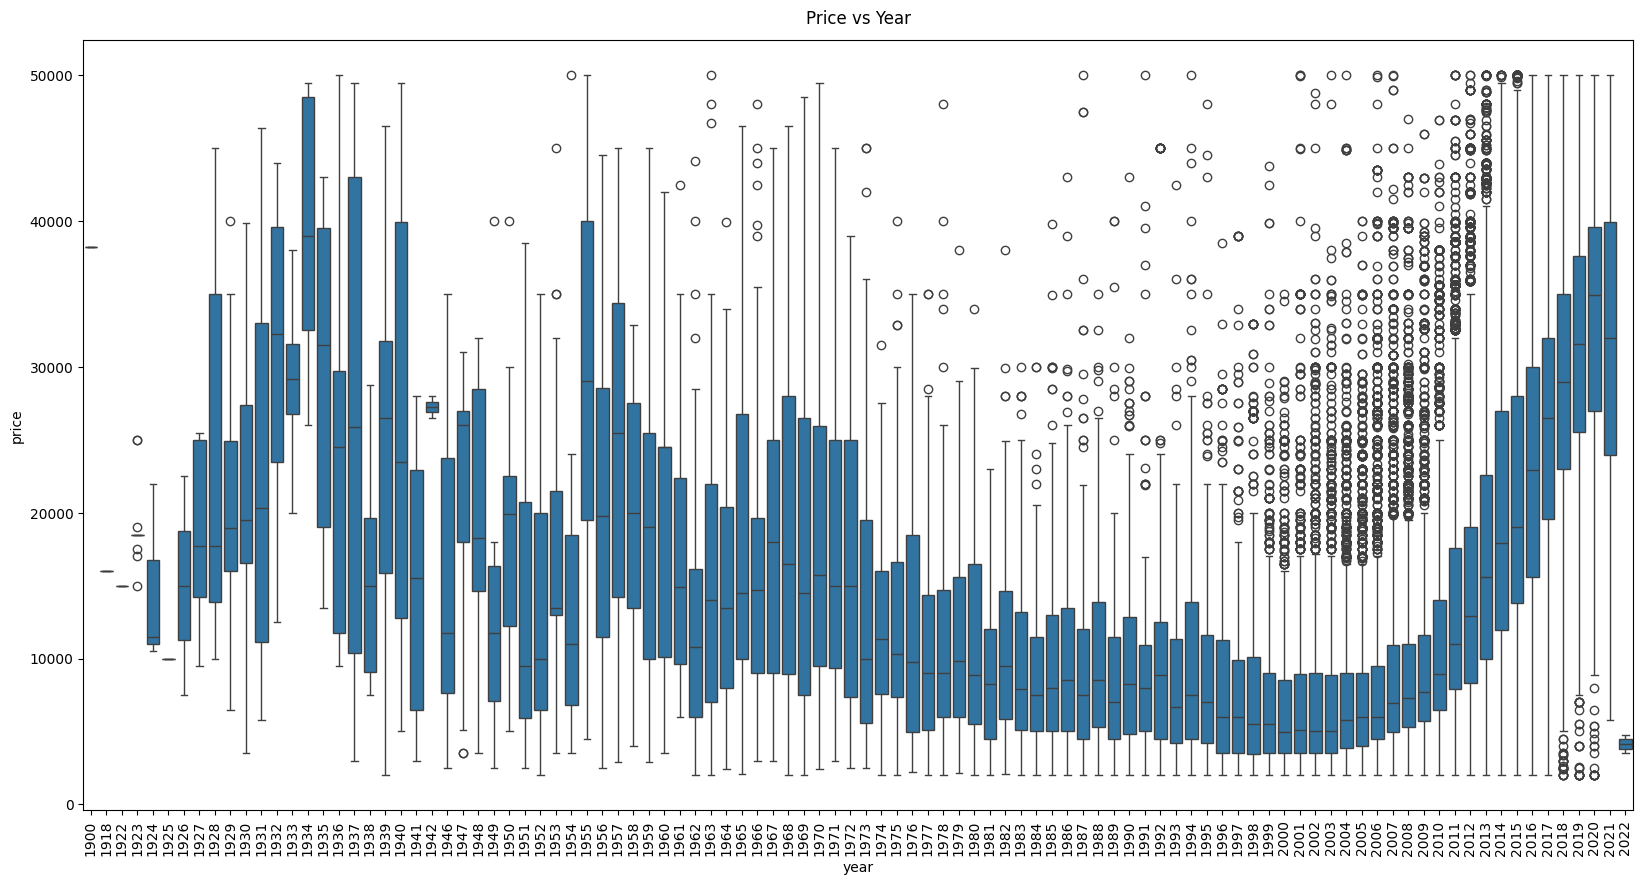

In [18]:
f, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Price vs Year', pad=12)
fig = sns.boxplot(x=vehicles_odo.year.astype(int), y='price', data=vehicles_odo)
plt.xticks(rotation=90);

*It appears that there is some inconsistency in the first 2/3rds of the dataset.*

*Price seems to consistently rise 2000 onwards until about 2021; and there seems to be some bad data for 2022 as well.*

*Filtering the dataset between 2000 and 2020 for further analysis*

---



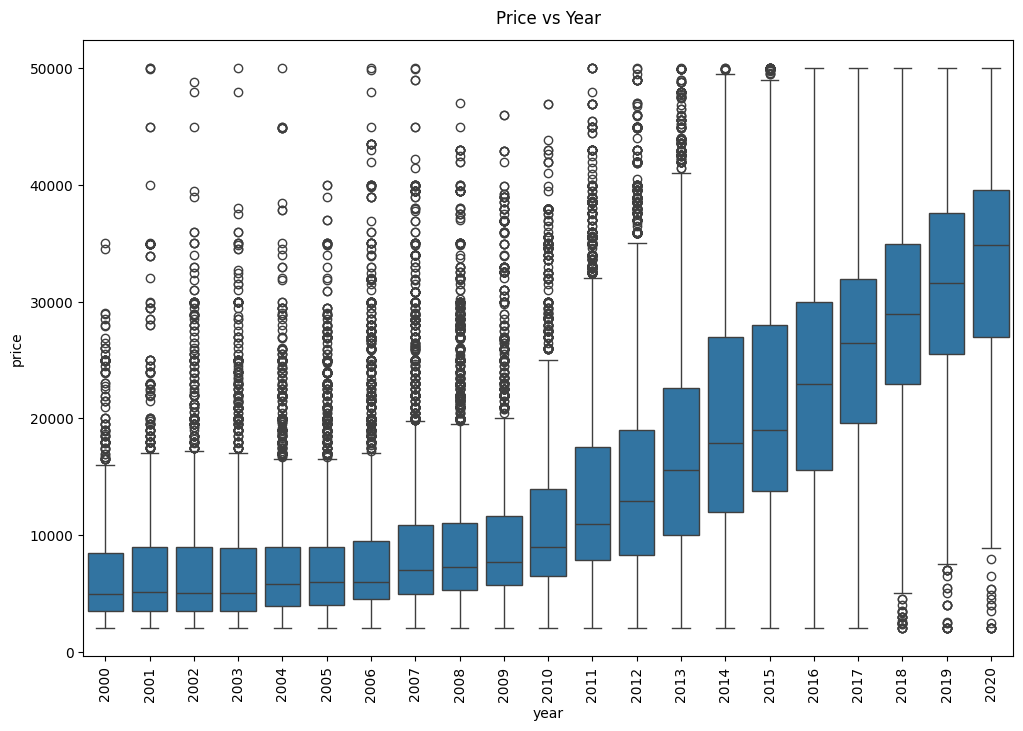

In [19]:
year_list = list(range(2000, 2021))

vehicles_year = vehicles_odo[vehicles_odo.year.astype(int).isin(year_list)]

# Plot again to visualize distribution
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price vs Year', pad=12)
fig = sns.boxplot(x=vehicles_year.year.astype(int), y='price', data=vehicles_year)
plt.xticks(rotation=90);

*With this used 20 year set, next, trying to find how the three features come together and depict real-worl characteristics.*
*Checking how price varies with mean odometer ratings over the age of the car posted.*

---


In [20]:
# Calculate age of the posted car using "posting date"
# Convert year and posting date to datetime
vehicles_year.posting_date = pd.to_datetime(vehicles_year.posting_date, utc=True)
# Remove timezone information to get naive datetime
vehicles_year.posting_date = vehicles_year.posting_date.dt.tz_localize(None)

# Add a new field for age of cars
vehicles_year['age'] = vehicles_year.posting_date.dt.year.astype(int) - vehicles_year.year.astype(int)

# Get a preview of the changes
vehicles_year.head()

,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,posting_date,age
0,33590,2014,gmc,sierra 1500 crew cab slt,good,gas,"57,923.00",clean,other,pickup,2021-05-04 17:31:18,7
1,22590,2010,chevrolet,silverado 1500,good,gas,"71,229.00",clean,other,pickup,2021-05-04 17:31:08,11
2,39590,2020,chevrolet,silverado 1500 crew,good,gas,"19,160.00",clean,other,pickup,2021-05-04 17:31:25,1
3,30990,2017,toyota,tundra double cab sr,good,gas,"41,124.00",clean,other,pickup,2021-05-04 15:41:31,4
4,15000,2013,ford,f-150 xlt,excellent,gas,"128,000.00",clean,automatic,truck,2021-05-03 19:02:03,8


In [21]:
vehicles_year.dtypes

,0
price,int64
year,object
manufacturer,object
model,object
condition,object
fuel,object
odometer,float64
title_status,object
transmission,object
type,object


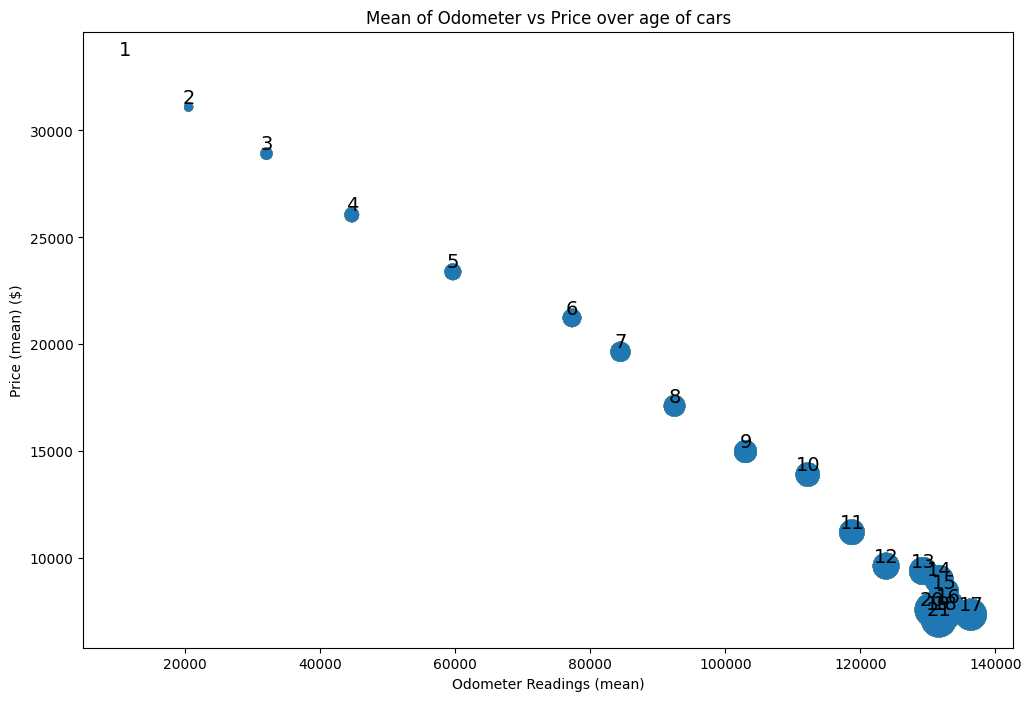

In [22]:
# Get mean of odometer readings by age
grp_df = vehicles_year.groupby('age')[['price', 'odometer']].mean().astype(int).reset_index()

# Visualize how odometer average readings vary with price over age of cars
# Set axes and points
x = x=grp_df.odometer
y = grp_df.price
points = grp_df.age
s = [30*n for n in range(len(y))]

f, ax = plt.subplots(figsize=(12, 8))
# Plot for each year
plt.title(f"Mean of Odometer vs Price over age of cars")
plt.xlabel("Odometer Readings (mean)")
plt.ylabel("Price (mean) ($)")

# Add labels for weeks
for i, week in enumerate(points):
    plt.annotate(week, (x[i], y[i]), size=14, va="bottom", ha="center")
    plt.scatter(x, y, s=s)

plt.show()

*It's evident from the visualization above that cars that have been driven less are more expensive than older cars which have been driven more. There seem to be a good chunk of cars under 10k that have been driven 120k and over and are 12 years and older - this is an interesting insight.*

---



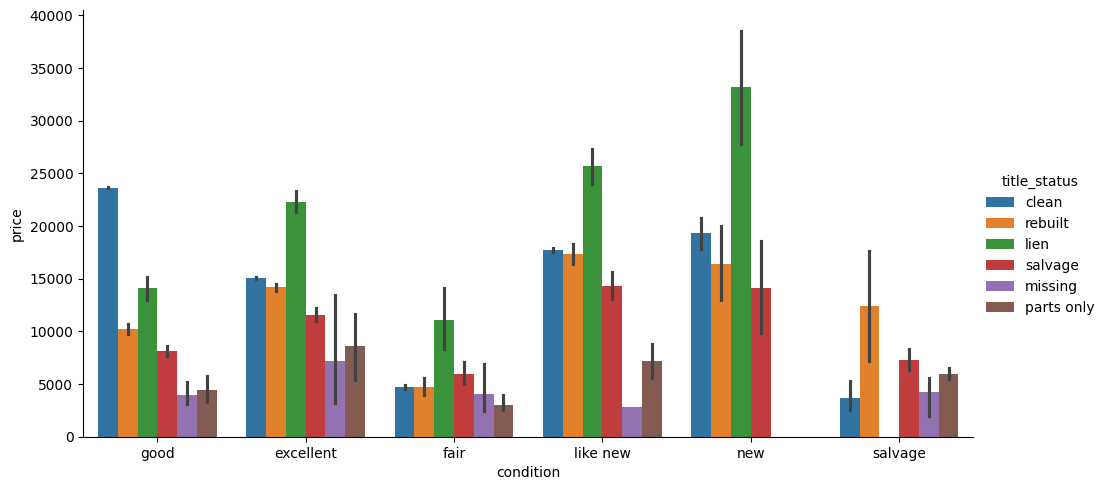

In [23]:
sns.catplot(x='condition', y ='price', hue='title_status', data=vehicles_year,
             kind="bar", aspect=2, height=5)

*Since we want to look at only used cars, ignoring new cars for the moment*.

*It also looks like there are only parts being sold - which might affect the price.*

*Removing both these attributes..*

---

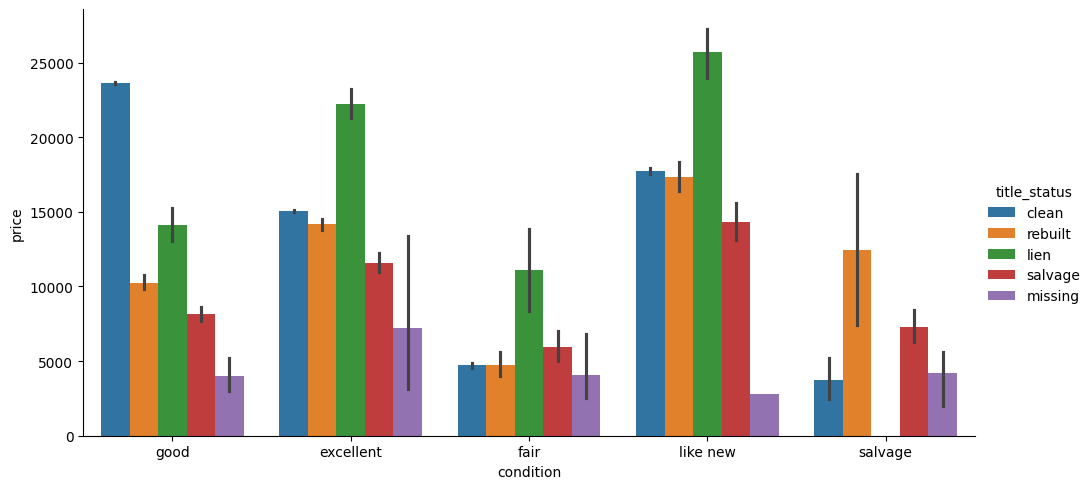

In [24]:
vehicles_used = vehicles_year[vehicles_year.condition != 'new']

vehicles_used = vehicles_used[vehicles_used.title_status != 'parts only']

sns.catplot(x='condition', y ='price', hue='title_status', data=vehicles_used,
            kind="bar", aspect=2, height=5)

#del vehicles_year

*On to the next, understanding how price of cars is affected by the fuel and trasmission features...*

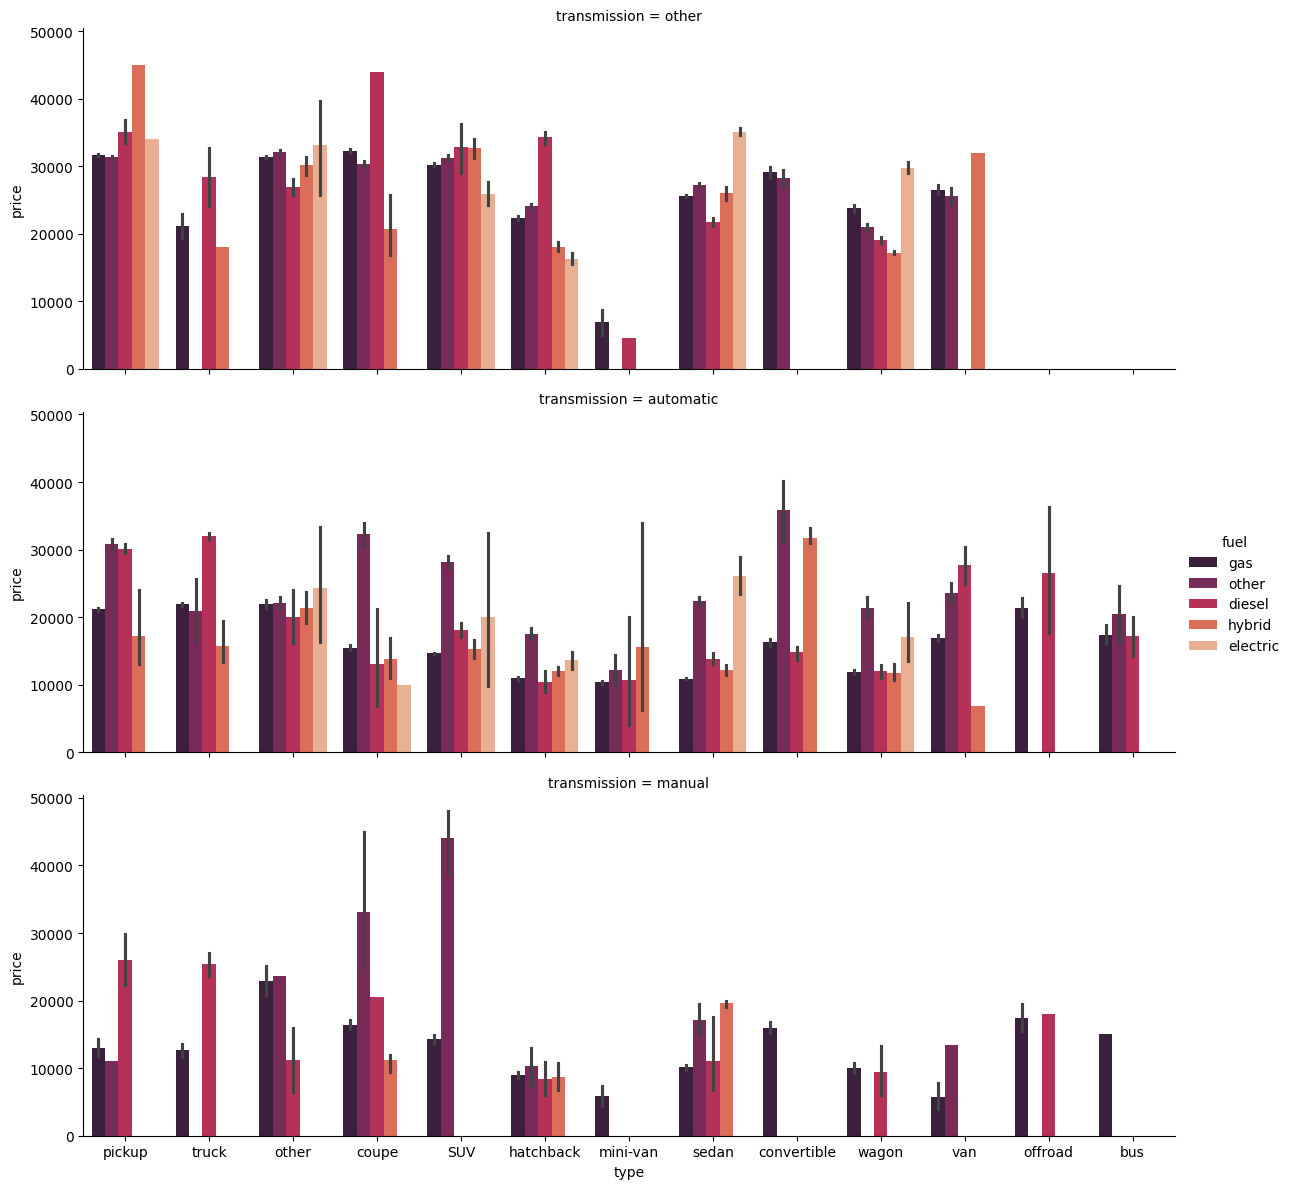

In [25]:
# Categorical plot between fuel and price for each type of trasmission
sns.catplot(x='type', y ='price', hue='fuel', col='transmission', data=vehicles_used, kind="bar",
            aspect=3, height=4,  palette="rocket", col_wrap=1)


*From the above visualization, it's noted that "other" values for type of fuels and trasmissions contribute to a considerable volume of data.*

*These, which are not a lot of value might affect the overall accuracy - hence removing them..*

---


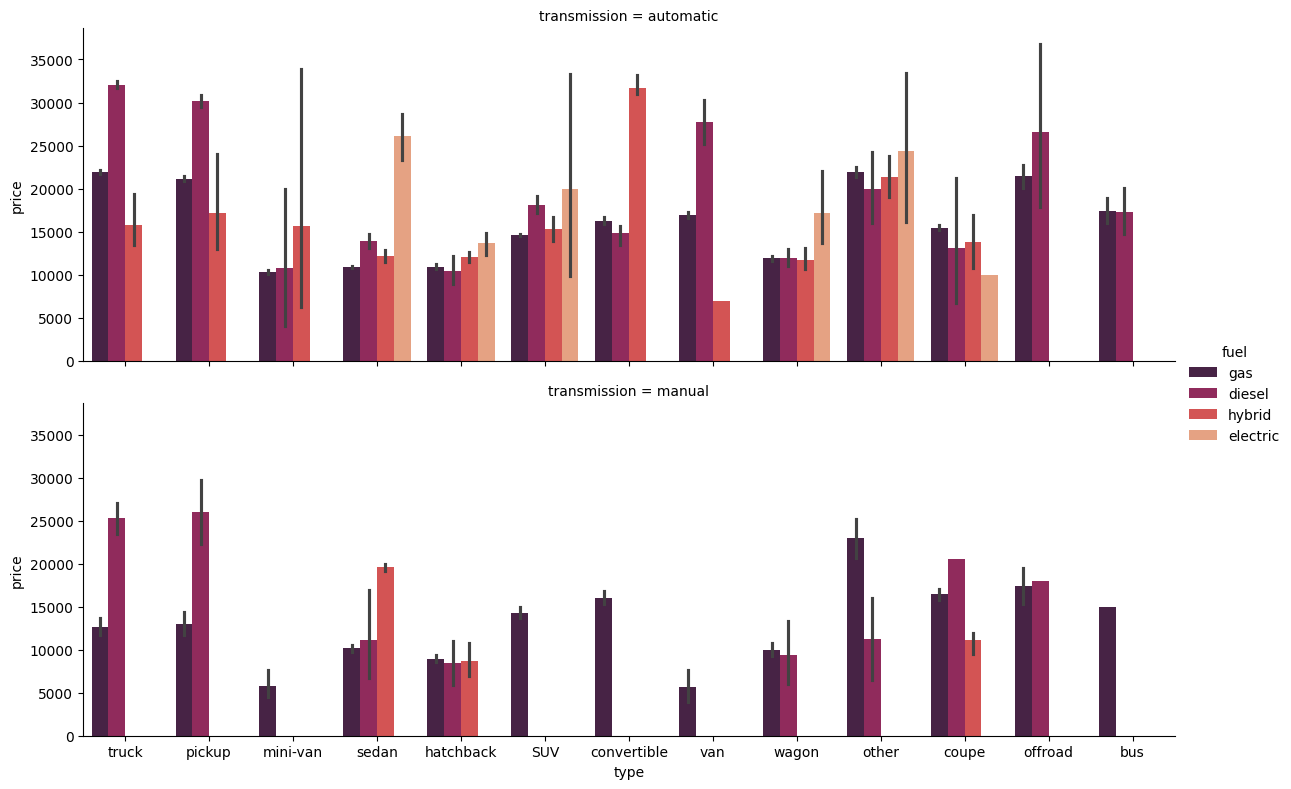

In [26]:
# Remove "other" types of fuel
vehicles_used = vehicles_used[(vehicles_used.fuel != 'other')]

# Remove "other" type of trasmissions
vehicles_used = vehicles_used[(vehicles_used.transmission != 'other')]

# Plot again to visualize
sns.catplot(x='type', y ='price', hue='fuel', col='transmission', data=vehicles_used, kind="bar",
            aspect=3, height=4,  palette="rocket", col_wrap=1)


In [27]:
vehicles_used.dtypes

,0
price,int64
year,object
manufacturer,object
model,object
condition,object
fuel,object
odometer,float64
title_status,object
transmission,object
type,object


*Next, we see how price is related to different kinds of manufacturers and the models they produce.*

---

In [28]:
# # Visualize the relationship of average price by manufacturer
# vehicles_used['price'] = pd.to_numeric(vehicles_used['price'], errors='coerce')

# grp_man_df = vehicles_used.groupby('manufacturer').mean()['price'].reset_index()

# x = grp_man_df.manufacturer
# y = grp_man_df.price
# y_mean = [np.median(y)]*len(grp_man_df)

# f, ax = plt.subplots(figsize=(12, 8))
# ax.scatter(x, y, s=y/100)
# ax.plot(x, y_mean, label='Median price', linestyle='--')

# plt.title(f"Mean Prices by Manufacturer")
# plt.ylabel("Price (mean)")
# plt.xlabel("Manufacturer")
# plt.xticks(rotation=90)
# plt.legend()
# plt.show()

*It's obviously evident that luxury brands have a higer price, but except a couple outliers, the median price lies near most points*

*Finally, we explore the "model" feature which I imagine has the highest cardinality amongst all the features we've seen so far..*

---


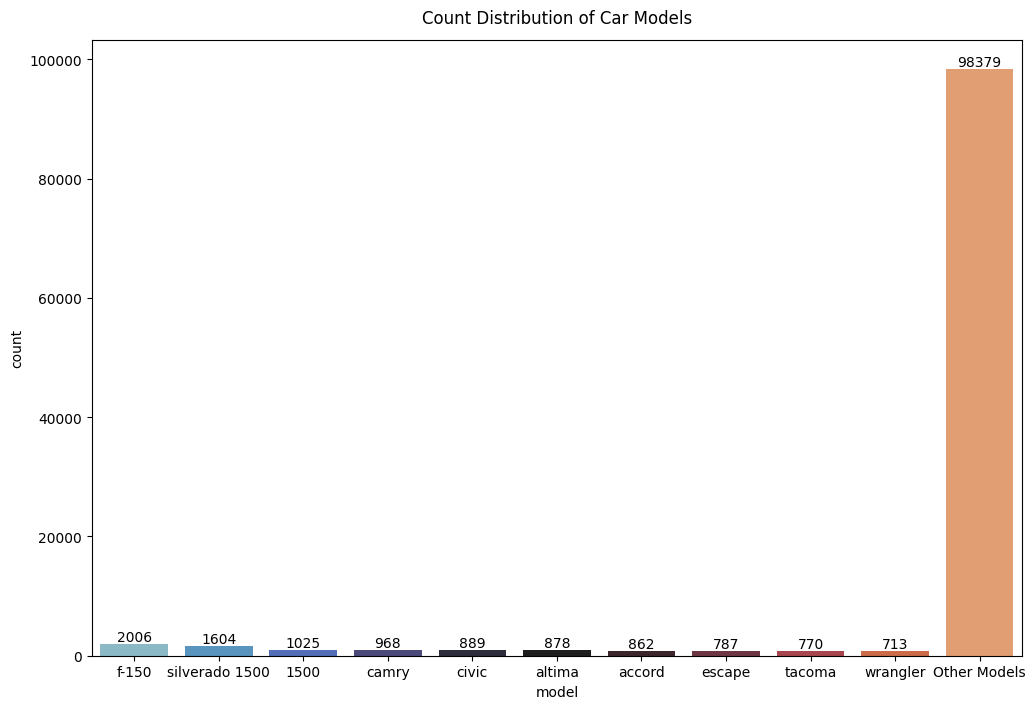

In [29]:
# Add a field for row numbers
vehicles_used['row_num'] = np.arange(len(vehicles_used))

# Get counts of models
model_df = vehicles_used.groupby(by="model").count()['row_num'].reset_index()
model_df.columns=(['model','count'])

# Get only 10 frequent models and how much the other account to
lar10_df = model_df.nlargest(10, columns='count')
lar10_df.index = range(len(lar10_df))

# Get count of all other models and append to the end of data drame
other_val_sum = model_df[~model_df['model'].isin(lar10_df.model)].sum().T['count']
lar10_df.loc[10] = ['Other Models',other_val_sum]

# Plot what the counts of models look like
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Count Distribution of Car Models', pad=12)
sns.barplot(x="model", y="count",  palette="icefire",  data=lar10_df)
show_values_on_bars(ax)

*As noted above, the "model" field has very high cardinality and this would have to be encoded with one of the encoders as they describe [in this (slightly older) article](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)*

 *I do want to note here that I want to experiment without dropping this high cardinality feature and work with models - if the accuracy turns to be too low, it's worth exploring without this feature*

 ---

In [30]:
vehicles_used["model"].unique()

array(['f-150 xlt', 'tacoma', 'f250 super duty', ..., 'f150, xlt',
       'f150, platinum', 'cruze, 2lt'], dtype=object)

# Encoding Categorical Data

*Since almost all features are categorical in this dataset, we'd have to encode them. I use Label Encoding*

---








In [31]:
# Get current information of the dataset
vehicles_used.info()

# Drop columns populated during clean-up or not required
vehicles_used.drop(columns=['posting_date','row_num'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 108881 entries, 4 to 202116
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   price         108881 non-null  int64         
 1   year          108881 non-null  object        
 2   manufacturer  108881 non-null  object        
 3   model         108881 non-null  object        
 4   condition     108881 non-null  object        
 5   fuel          108881 non-null  object        
 6   odometer      108881 non-null  float64       
 7   title_status  108881 non-null  object        
 8   transmission  108881 non-null  object        
 9   type          108881 non-null  object        
 10  posting_date  108881 non-null  datetime64[ns]
 11  age           108881 non-null  int64         
 12  row_num       108881 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 15.7+ MB


In [32]:
# Make a copy of the data frame for encoding
vehicles_used_enc = vehicles_used.copy()
vehicles_used_enc.info()


<class 'pandas.core.frame.DataFrame'>
Index: 108881 entries, 4 to 202116
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         108881 non-null  int64  
 1   year          108881 non-null  object 
 2   manufacturer  108881 non-null  object 
 3   model         108881 non-null  object 
 4   condition     108881 non-null  object 
 5   fuel          108881 non-null  object 
 6   odometer      108881 non-null  float64
 7   title_status  108881 non-null  object 
 8   transmission  108881 non-null  object 
 9   type          108881 non-null  object 
 10  age           108881 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 14.0+ MB


In [33]:
# Get fields that are categorical
cat_features = vehicles_used_enc.select_dtypes(exclude=np.number).columns.to_list()
print(f'Categorical features: {cat_features}\n\n')

label_mappings = {}

# Encode using LabelEncoder
for c in cat_features:
      le = LabelEncoder()
      le.fit(list(vehicles_used_enc[c].astype(str).values))

      # label_mappings[c] = dict(zip(le.classes_, le.transform(le.classes_)))
      label_mappings[c] = {str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}

      vehicles_used_enc[c] = le.transform(list(vehicles_used_enc[c].astype(str).values))


# Encode "model" using OneHotEncoder
# model_arr = vehicles_used_enc.model.values.reshape(-1,1)
# oh = OneHotEncoder()
# model_encoded = oh.fit_transform(model_arr)
# vehicles_used_enc.model = oh.transform(model_arr)


vehicles_used_enc

Categorical features: ['year', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type']




,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,age
4,15000,13,11,3946,0,2,"128,000.00",0,0,10,8
7,35000,19,36,8522,0,2,"43,000.00",0,0,10,2
27,19900,4,11,4267,2,0,"88,000.00",0,0,8,17
31,14000,12,14,6413,0,2,"95,000.00",0,0,5,9
37,22500,1,11,4368,2,0,"144,700.00",0,1,10,20
...,...,...,...,...,...,...,...,...,...,...,...
202106,39990,17,16,7038,2,2,"41,664.00",0,0,7,4
202108,29590,16,36,738,2,2,"53,475.00",0,0,0,5
202110,32990,16,16,7038,2,2,"55,612.00",0,0,7,5
202115,30990,18,24,4936,2,2,"15,080.00",0,0,7,3


In [34]:
import json
with open('label_mappings.json', 'w') as f:
    json.dump(label_mappings, f, indent=4)

In [35]:
for feature, mapping in label_mappings.items():
    print(f'Mapping for {feature}: {mapping}\n')

Mapping for year: {'2000': 0, '2001': 1, '2002': 2, '2003': 3, '2004': 4, '2005': 5, '2006': 6, '2007': 7, '2008': 8, '2009': 9, '2010': 10, '2011': 11, '2012': 12, '2013': 13, '2014': 14, '2015': 15, '2016': 16, '2017': 17, '2018': 18, '2019': 19, '2020': 20}

Mapping for manufacturer: {'acura': 0, 'alfa-romeo': 1, 'aston-martin': 2, 'audi': 3, 'bmw': 4, 'buick': 5, 'cadillac': 6, 'chevrolet': 7, 'chrysler': 8, 'dodge': 9, 'fiat': 10, 'ford': 11, 'gmc': 12, 'harley-davidson': 13, 'honda': 14, 'hyundai': 15, 'infiniti': 16, 'jaguar': 17, 'jeep': 18, 'kia': 19, 'land rover': 20, 'lexus': 21, 'lincoln': 22, 'mazda': 23, 'mercedes-benz': 24, 'mercury': 25, 'mini': 26, 'mitsubishi': 27, 'nissan': 28, 'pontiac': 29, 'porsche': 30, 'ram': 31, 'rover': 32, 'saturn': 33, 'subaru': 34, 'tesla': 35, 'toyota': 36, 'volkswagen': 37, 'volvo': 38}

Mapping for model: {'& altima': 0, '(300)': 1, '* vmi * ♿': 2, '-': 3, '- benz sprinter': 4, '- international': 5, '- santa fe': 6, '- tc3 - 3500 hd': 7,

In [36]:
# prompt: need to get only the manufacturer and their models

manufacturer_models = vehicles_used_enc.groupby("manufacturer")[['manufacturer', 'model']]
print(manufacturer_models)


In [37]:
vehicles_used

,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,age
4,15000,2013,ford,f-150 xlt,excellent,gas,"128,000.00",clean,automatic,truck,8
7,35000,2019,toyota,tacoma,excellent,gas,"43,000.00",clean,automatic,truck,2
27,19900,2004,ford,f250 super duty,good,diesel,"88,000.00",clean,automatic,pickup,17
31,14000,2012,honda,odyssey,excellent,gas,"95,000.00",clean,automatic,mini-van,9
37,22500,2001,ford,f450,good,diesel,"144,700.00",clean,manual,truck,20
...,...,...,...,...,...,...,...,...,...,...,...
202106,39990,2017,infiniti,qx80 sport utility 4d,good,gas,"41,664.00",clean,automatic,other,4
202108,29590,2016,toyota,4runner sr5 sport utility,good,gas,"53,475.00",clean,automatic,SUV,5
202110,32990,2016,infiniti,qx80 sport utility 4d,good,gas,"55,612.00",clean,automatic,other,5
202115,30990,2018,mercedes-benz,glc 300 sport,good,gas,"15,080.00",clean,automatic,other,3


In [38]:
vehicles_used_enc["model"].unique()

array([3946, 8522, 4267, ..., 4236, 4235, 2825])

<Axes: title={'center': 'Encoded Correlation Heatmap for Used Vehicles Dataset'}>

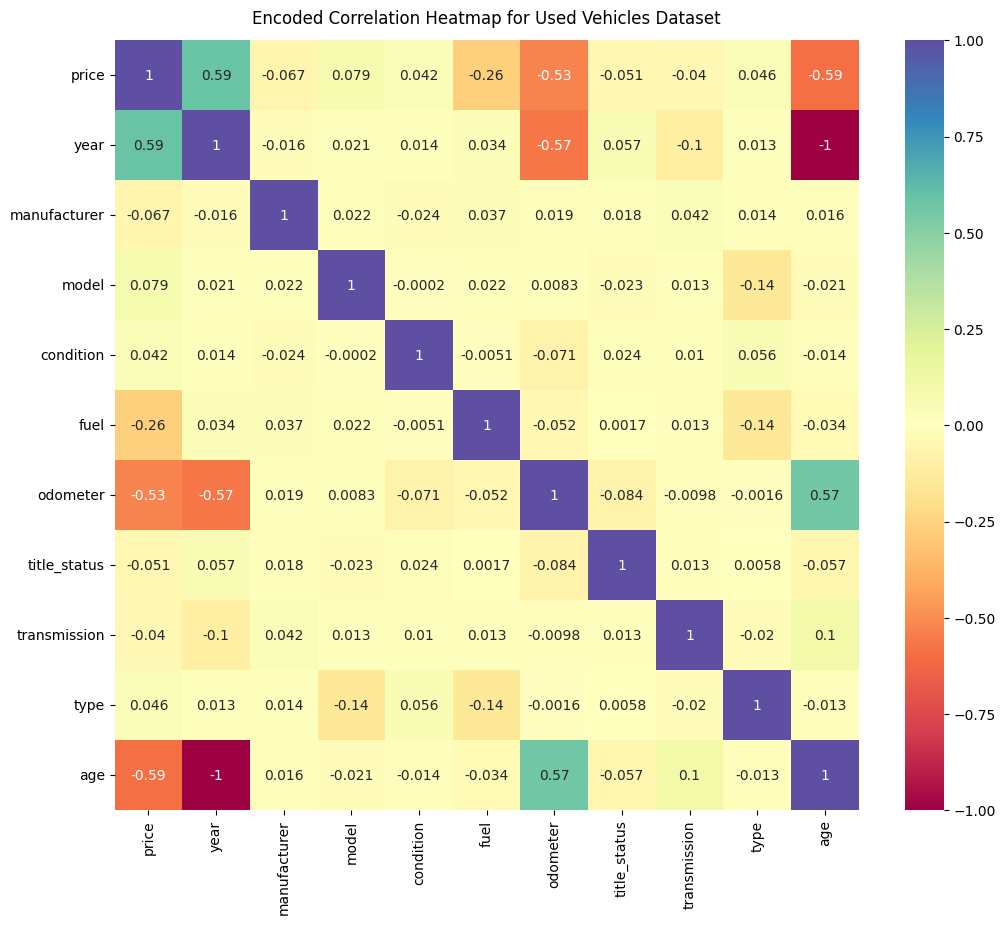

In [39]:
# Get the correlation matrix for the encoded data frame
f, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Encoded Correlation Heatmap for Used Vehicles Dataset', pad=12)
sns.heatmap(vehicles_used_enc.corr(), vmin=-1, vmax=1, annot=True, cmap='Spectral')


# Preparing Data and Modeling
## *Data Prep*


In [40]:
# X will be all features except price
feature_cols = vehicles_used_enc.columns.values.tolist()
feature_cols.remove('price')
#feature_cols.remove('model')
X = vehicles_used_enc[feature_cols]

# Y will be the target col = price
Y = vehicles_used_enc['price']

print(f"X (features):\n\n{X}")

print(f"\nY (target):\n\n{Y}")

X (features):

        year  manufacturer  model  condition  fuel   odometer  title_status  transmission  type  age
4         13            11   3946          0     2 128,000.00             0             0    10    8
7         19            36   8522          0     2  43,000.00             0             0    10    2
27         4            11   4267          2     0  88,000.00             0             0     8   17
31        12            14   6413          0     2  95,000.00             0             0     5    9
37         1            11   4368          2     0 144,700.00             0             1    10   20
...      ...           ...    ...        ...   ...        ...           ...           ...   ...  ...
202106    17            16   7038          2     2  41,664.00             0             0     7    4
202108    16            36    738          2     2  53,475.00             0             0     0    5
202110    16            16   7038          2     2  55,612.00             0 

In [41]:
#Splitting the dataset into training and testing sets for modeling later

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)



## *Modeling*

*Since the target field is non-catgorical, classifier I use regression rather than classification*.
*I start with Linear Regression and explore the variants of Decision Tree based models as below:*

Decision Trees --> Bagging --> Random Forest --> Boosting --> Gradient Boosting --> XGBoost

*References*
1. [Titanic Data Scince Solutions (Models)](https://www.kaggle.com/startupsci/titanic-data-science-solutions?scriptVersionId=10431564&cellId=77)
2. [XGBoost Algorithm](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

---

*To start with, define a function for regression metrics*

1. R² measures how much variability in dependent variable can be "explained by the model.
2. While R² is a relative measure of how well the model fits dependent variables, \nMean Square Error is an absolute measure of the goodness for the fit.
3. Mean Absolute Error(MAE) is similar to MSE, however, unlike MSE, MAE takes the sum of the ABSOLUTE value of error.

*[Regression Merics Reference](https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914)*

In [42]:
# Define a function for output statistics
def reg_metrics(pred_model, x_train, x_test, y_train, y_test):
    """ Function takes in training and testing sets, prediction model,
    and ouputs the below metrics:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    """
    # Get predicted values on x_test
    y_pred = pred_model.predict(x_test)

    #1 & 2 Coefficient of Determination (R² & Adjusted R²)
    print("\n\t--- Coefficient of Determination (R² & Adjusted R²) ---")
    r2 = metrics.r2_score(y_pred=y_pred, y_true=y_test)
    adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

    print(f"R²\t\t: {round(r2, 2)}")
    print(f"Adjusted R²\t: {round(adj_r2, 2)}")


    #3 & 4. MSE and RMSE
    print("\n\t--- Mean Squared Error (MSE & RMSE) ---")

    mse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
    rmse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)

    print(f"MSE\t: {round(mse, 2)}")
    print(f"RMSE\t: {round(rmse, 2)}")


    #5. MAE
    print("\n\t--- Mean Absolute Error (MAE) ---")
    mae = metrics.mean_absolute_error(y_pred=y_pred, y_true=y_test)
    print(f"MAE\t: {round(mae, 2)}")

    # Return Accuracy
    train_acc = round(pred_model.score(x_train, y_train)*100, 2)
    test_acc = round(pred_model.score(x_test, y_test)*100, 2)

    return (train_acc, test_acc)


In [43]:
# Define a dataframe to summarize accuracies for later
algo_list = ['Linear Regression','Decision Trees', 'Bagging', 'Random Forest', 'Adaptive Boosting', 'Gradient Boosting', 'XGBoost']
acc_cols = ['Training Accuracy', 'Testing Accuracy']

acc_df = pd.DataFrame(columns=acc_cols, index=algo_list)

acc_df.index.name='Algorithm'


In [44]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)
print("\t------- Linear Regression -------")
linreg_acc = reg_metrics(linear_reg, x_train, x_test, y_train, y_test)

acc_df.loc['Linear Regression'] = linreg_acc

	------- Linear Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.51
Adjusted R²	: 0.51

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 53709306.39
RMSE	: 7328.66

	--- Mean Absolute Error (MAE) ---
MAE	: 5660.74


In [45]:
# Decision Tree
# A graphical representation of possible solutions to a decision based on certain conditions

dtree_reg = DecisionTreeRegressor()
dtree_reg.fit(x_train, y_train)

print("\t------- Decision Tree Regression -------")
dtree_acc = reg_metrics(dtree_reg, x_train, x_test, y_train, y_test)

acc_df.loc['Decision Trees'] = dtree_acc

	------- Decision Tree Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.83
Adjusted R²	: 0.83

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 18497051.61
RMSE	: 4300.82

	--- Mean Absolute Error (MAE) ---
MAE	: 2127.72


In [46]:
# Bagging Regression
# Meta-algorithm combining predictions from multiple-decision
#  trees through a majority voting mechanism

bag_reg = BaggingRegressor()
bag_reg.fit(x_train, y_train)

print("\t------- Bagging Regression -------")
bag_acc = reg_metrics(bag_reg, x_train, x_test, y_train, y_test)

acc_df.loc['Bagging'] = bag_acc



	------- Bagging Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.89
Adjusted R²	: 0.89

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 11498902.23
RMSE	: 3391.0

	--- Mean Absolute Error (MAE) ---
MAE	: 1876.74


In [47]:
# Random Forest Regression
# Bagging-based algorithm where only a subset of features are selected at
# random to build a forest or collection of decision trees

rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)

print("\t------- Random Forest Regression -------")
rf_acc = reg_metrics(rf_reg, x_train, x_test, y_train, y_test)

acc_df.loc['Random Forest'] = rf_acc

	------- Random Forest Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.9
Adjusted R²	: 0.9

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 10425596.38
RMSE	: 3228.87

	--- Mean Absolute Error (MAE) ---
MAE	: 1781.81


In [48]:
# Adaboost Regression
# Models are built sequentially by minimizing the errors from previous models while
# increasing (or boosting) influence ofnigh-performing models
ab_reg = AdaBoostRegressor()
ab_reg.fit(x_train, y_train)


print("\t------- Adaboost Regression -------")
ab_acc = reg_metrics(ab_reg, x_train, x_test, y_train, y_test)

acc_df.loc['Adaptive Boosting'] = ab_acc


	------- Adaboost Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.37
Adjusted R²	: 0.37

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 69126912.15
RMSE	: 8314.26

	--- Mean Absolute Error (MAE) ---
MAE	: 7204.12


In [49]:
# Gradient Boosting Regression
# Gradient Boosting employs gradient descent algorithm to minimize errors in sequential models

gb_reg = GradientBoostingRegressor()
gb_reg.fit(x_train, y_train)


print("\t------- Gradient Boosting Regression -------")
gb_acc = reg_metrics(gb_reg, x_train, x_test, y_train, y_test)

acc_df.loc['Gradient Boosting'] = gb_acc


	------- Gradient Boosting Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.76
Adjusted R²	: 0.76

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 26478883.47
RMSE	: 5145.76

	--- Mean Absolute Error (MAE) ---
MAE	: 3602.39


In [50]:
# XGBoost
# Optimized Gradient Boosting algorithm through parallel processing, tree-pruning,
# handling missing values and regularization to avoid overfitting/bias

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(x_train, y_train)

print("\t------- XGBoost Regression -------")
xgb_acc = reg_metrics(xgb_reg, x_train, x_test, y_train, y_test)

acc_df.loc['XGBoost'] = xgb_acc

	------- XGBoost Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.88
Adjusted R²	: 0.88

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 12715479.58
RMSE	: 3565.88

	--- Mean Absolute Error (MAE) ---
MAE	: 2357.63


**Great Accuracy!**

*Now moving on to summarize and concluding this project..*
*From the above, it's evident that Random Forest gives the best accuracy of ~90%.*

# *Summary & Conclusion*

In [51]:
# All accuracies from the above algorithms
acc_df.astype(str) + '%'

,Training Accuracy,Testing Accuracy
Algorithm,,
Linear Regression,50.21%,50.87%
Decision Trees,99.99%,83.08%
Bagging,98.12%,89.48%
Random Forest,98.65%,90.46%
Adaptive Boosting,37.12%,36.77%
Gradient Boosting,75.41%,75.78%
XGBoost,90.36%,88.37%


In [52]:
import pickle
# Linear Regression
with open('linear_reg.pkl', 'wb') as f:
    pickle.dump(linear_reg, f)

#Decision Trees
with open('dtree_reg.pkl', 'wb') as f:
    pickle.dump(dtree_reg, f)

#Bagging
with open('bag_reg.pkl', 'wb') as f:
    pickle.dump(bag_reg, f)

#Random Forest
with open('rf_reg.pkl', 'wb') as f:
    pickle.dump(rf_reg, f)

#Adaptive Boosting
with open('ab_reg.pkl', 'wb') as f:
    pickle.dump(ab_reg, f)

#Gradient Boosting
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(gb_reg, f)

#XGBoost
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_reg, f)

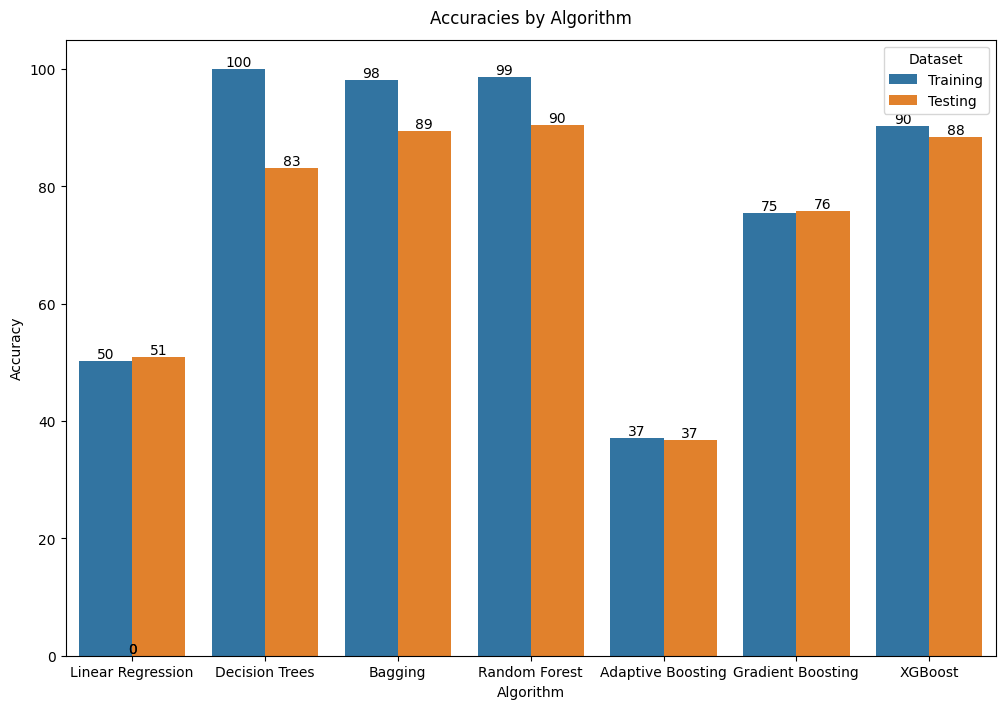

In [53]:
# Rearrange the data frame
acc_df.columns=['Training','Testing']
acc_plot_df = acc_df.reset_index().melt(id_vars=['Algorithm'])
acc_plot_df.columns=['Algorithm','Dataset','Accuracy']

# Plot the final accuracies
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x="Algorithm", y="Accuracy", hue="Dataset", data=acc_plot_df)
ax.set_title("Accuracies by Algorithm", pad=12)
show_values_on_bars(ax)


>**From the above, it's evident that each algorithm has a method of working but they accomplish a common goal.**


>**Which one to choose and the best one to use would have to be determined per requirements at hand.**